--- RELATÓRIO DE PASSIVO CONTINGENTE ---
Número de Simulações: 10000
Valor Médio Esperado (Provisão Sugerida): R$ 1,952,428.36
Risco de Cauda (VaR 95%): R$ 2,351,332.75
Cenário de Catástrofe (VaR 99%): R$ 2,521,534.19
Diferença (Capital em Risco não provisionado): R$ 398,904.39


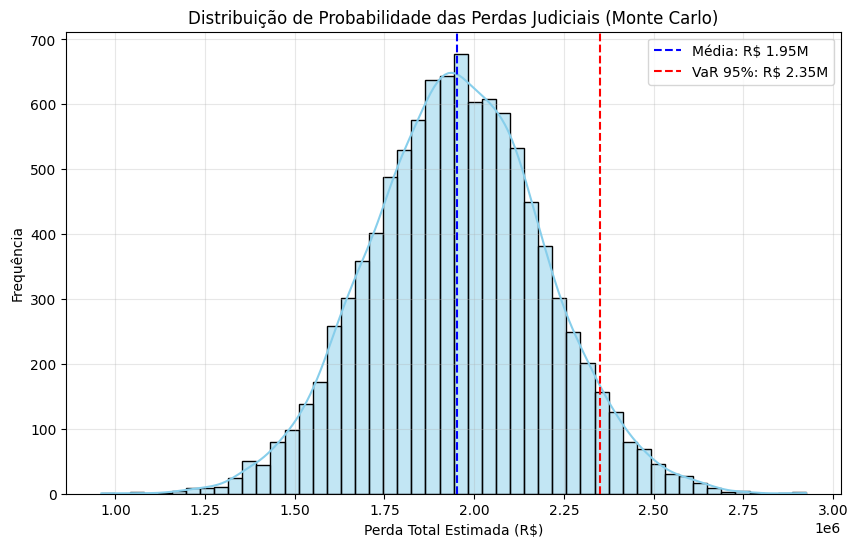

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configurações de Reprodutibilidade (Seed)
np.random.seed(42)

# ==========================================
# 1. PARÂMETROS DA CARTEIRA JURÍDICA
# ==========================================
n_processos = 50              # Quantidade de processos ativos
n_simulacoes = 10000          # Quantidade de cenários futuros simulados (Iterações)

# Parâmetros dos Processos (Estimativas do Perito)
media_valor_pedido = 100000   # Valor médio pedido pelo autor na inicial
desvio_valor_pedido = 20000   # Variação padrão dos pedidos

prob_perda_base = 0.60        # 60% de chance de perder (Baseado em Jurisprudência)

# Fator de "Corte" do Juiz (Se perder, quanto paga?)
# O juiz costuma dar entre 50% e 80% do pedido. Vamos modelar como média 65% e desvio 10%
fator_condenacao_medio = 0.65
fator_condenacao_std = 0.10

# ==========================================
# 2. MOTOR DE MONTE CARLO
# ==========================================
resultados_totais = []

for i in range(n_simulacoes):

    # Passo A: Gerar os valores das causas individuais (Distribuição Normal)
    # Nem todo processo é de 100k, uns são 80k, outros 120k...
    valores_pedidos = np.random.normal(media_valor_pedido, desvio_valor_pedido, n_processos)
    valores_pedidos = np.maximum(valores_pedidos, 0) # Garantir que não haja valor negativo

    # Passo B: Simular o Veredito (Bernoulli / Binomial)
    # 1 = Perdeu o processo, 0 = Ganhou
    veredito = np.random.binomial(1, prob_perda_base, n_processos)

    # Passo C: Simular o "Quantum" (Quanto o juiz arbitra)
    # Apenas para os casos onde houve derrota (veredito == 1)
    fator_juiz = np.random.normal(fator_condenacao_medio, fator_condenacao_std, n_processos)
    fator_juiz = np.clip(fator_juiz, 0.1, 1.0) # O juiz dá entre 10% e 100% do pedido

    # Passo D: Calcular o prejuízo total deste cenário
    perdas_individuais = valores_pedidos * veredito * fator_juiz
    perda_total_cenario = np.sum(perdas_individuais)

    resultados_totais.append(perda_total_cenario)

# Convertendo para array numpy para facilitar estatística
resultados_totais = np.array(resultados_totais)

# ==========================================
# 3. ANÁLISE DOS RESULTADOS (JURIMETRIA)
# ==========================================
media_esperada = np.mean(resultados_totais)
var_95 = np.percentile(resultados_totais, 95) # Value at Risk (Pior cenário em 95% das vezes)
var_99 = np.percentile(resultados_totais, 99) # Stress Test

print(f"--- RELATÓRIO DE PASSIVO CONTINGENTE ---")
print(f"Número de Simulações: {n_simulacoes}")
print(f"Valor Médio Esperado (Provisão Sugerida): R$ {media_esperada:,.2f}")
print(f"Risco de Cauda (VaR 95%): R$ {var_95:,.2f}")
print(f"Cenário de Catástrofe (VaR 99%): R$ {var_99:,.2f}")
print(f"Diferença (Capital em Risco não provisionado): R$ {var_95 - media_esperada:,.2f}")

# ==========================================
# 4. VISUALIZAÇÃO GRÁFICA
# ==========================================
plt.figure(figsize=(10, 6))
sns.histplot(resultados_totais, kde=True, color='skyblue', bins=50)
plt.axvline(media_esperada, color='blue', linestyle='--', label=f'Média: R$ {media_esperada/1e6:.2f}M')
plt.axvline(var_95, color='red', linestyle='--', label=f'VaR 95%: R$ {var_95/1e6:.2f}M')

plt.title('Distribuição de Probabilidade das Perdas Judiciais (Monte Carlo)')
plt.xlabel('Perda Total Estimada (R$)')
plt.ylabel('Frequência')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()